# Variational Autoencoders

In [19]:
#imports
from tensorflow.keras.layers import Dense, Activation, Add, Multiply, Input, Reshape, Lambda, Concatenate
from tensorflow.keras.models import Model
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

#get data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.
x_test = x_test.reshape(-1, 784).astype('float32') / 255.

#x_train = np.expand_dims(x_train, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)

#set parameters
middle_layer = 512
latent_size = 3
EPOCHS = 50
BATCH_SIZE = 1000


In [3]:
x_train.shape

(60000, 784)

In [ ]:
#create model
inp = Input(shape=(784,), name="input")
enc = Dense(middle_layer, activation='relu', name="encoding1")(inp)
enc_sigma = Dense(latent_size, name="encoding2_Sigma")(enc)
enc_mu = Dense(latent_size, name="encoding2_Mu")(enc)
#eps = Input(tensor=tfp.Normal().sample(latent_size))
#tmp = Multiply()([enc_sigma, eps])
#latent = Add()([enc_mu, tmp])
concatenated_latent = Concatenate(axis=1,name="SigmaAndMu")([enc_sigma, enc_mu])
latent = Lambda(lambda ms: tfp.distributions.MultivariateNormalDiag(loc=ms[0], scale_diag=ms[1]).sample(), name="LatentEncoding")([enc_mu, enc_sigma])

encoder = Model(inputs=inp, outputs=latent, name="encoder")

inp_from_latent = Input(shape=[latent_size], name="input2")
dec = Dense(middle_layer, activation='relu', name="decoding1")(inp_from_latent)
dec = Dense(784, activation='relu', name="decoding2")(dec)
out_dist = Reshape([28, 28, 1], name="Reshape")(dec)
#out_dist_joint = Lambda(lambda decoded: tfp.distributions.Independent(tfp.distributions.Bernoulli(logits=out_dist), 2), output_shape=(1,1), name="BernoulliProbability")(dec)
#we cant do the lambda layer above, because it wont return anything; just instantiates distro. 
#BUT, there exists an actual tfp layer!! So apparently, you CAN return a distribution! :)
out_dist_joint = tfp.layers.IndependentBernoulli((28,28,1), tfp.distributions.Bernoulli.logits, name="Bernoulli")


decoder = Model(inputs=inp_from_latent, outputs=out_dist, name="decoder")

vae_model = Model(inputs=encoder.inputs, outputs=[concatenated_latent, out_dist_joint(decoder(latent))])#out_dist_joint(out_dist)])

vae_model.summary()
plot_model(vae_model, to_file='vae_model.png')

#kl_loss = tf.reduce_mean(- 0.5 * tf.reduce_sum(1 + enc_sigma - tf.square(enc_mu) - tf.exp(enc_sigma), axis=-1))
#reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inp, dec) * 784) #vae_model.outputs[0].log_prob(inp), axis=-1)
#vae_model.add_loss(kl_loss)
#vae_model.add_loss(reconstruction_loss)

In [4]:
print(tf.keras.backend.image_data_format())

channels_last


In [15]:
#create model
inp = Input(shape=(784,), name="input")
enc = Dense(middle_layer, activation='relu', name="encoding1")(inp)
enc_sigma = Dense(latent_size, name="Sigma")(enc)
enc_mu = Dense(latent_size, name="Mu")(enc)
#concatenated_latent = Concatenate(axis=1,name="SigmaAndMu")([enc_sigma, enc_mu])
#latent = Lambda(lambda ms: tfp.distributions.MultivariateNormalDiag(loc=ms[0], scale_diag=ms[1]).sample(sample_shape=tf.shape(enc_mu)), name="LatentEncoding")([enc_mu, enc_sigma])
latent = Lambda(lambda mu: mu[0] + tf.exp(0.5 * mu[1]) * tf.random_normal(shape=tf.shape(mu[0])), name="LatentEncoding")((enc_mu, enc_sigma))

encoder = Model(inputs=inp, outputs=[enc_mu, enc_sigma, latent])

inp_from_latent = Input(shape=latent_size, name="input2")
dec1 = Dense(middle_layer, activation='relu', name="decoding1")(inp_from_latent)
dec = Dense(784, activation='sigmoid', name="decoding2")(dec1)
##out_dist = Reshape([28, 28], name="Reshape")(dec)
#out_dist_joint = tfp.layers.IndependentBernoulli([784], tfp.distributions.Bernoulli.logits, name="Bernoulli")

decoder = Model(inputs=inp_from_latent, outputs=dec)

outs = decoder(latent)

#vae_model = Model(inputs=inp, outputs=[enc_mu, enc_sigma, out_dist_joint(dec)], name="VAE")
vae_model = Model(inputs=inp, outputs=outs, name="VAE")

vae_model.summary()
plot_model(vae_model, to_file='vae_model.png')



kl_loss = tf.reduce_mean(- 0.5 * tf.reduce_sum(1 + enc_sigma - tf.square(enc_mu) - tf.exp(enc_sigma), axis=-1))
reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inp, outs) * 784) #vae_model.outputs[0].log_prob(inp), axis=-1)
vae_model.add_loss(kl_loss)
vae_model.add_loss(reconstruction_loss)

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding1 (Dense)               (None, 512)          401920      input[0][0]                      
__________________________________________________________________________________________________
Mu (Dense)                      (None, 3)            1539        encoding1[0][0]                  
__________________________________________________________________________________________________
Sigma (Dense)                   (None, 3)            1539        encoding1[0][0]                  
________________________________________________________________________________________________

In [ ]:
#we need multiple losses:
def reconstruction_loss(y_true, y_pred):
    return - tf.reduce_mean(y_pred.log_prob(y_true), axis=-1)
def KL_loss_sigma(y_true, y_pred):
    return tf.reduce_mean(0.5*(-tf.reduce_sum(y_pred, axis=-1) + tf.reduce_sum(tf.exp(y_pred), axis=-1)))
def KL_loss_mu(y_true, y_pred):
    return tf.reduce_mean(0.5*(tf.reduce_sum(tf.square(y_pred), axis=-1) - tf.cast(tf.size(y_pred), tf.dtypes.float32)))

dummy = np.zeros(latent_size)
losses = {"Bernoulli" : reconstruction_loss,
          "Sigma" : KL_loss_sigma,
          "Mu" : KL_loss_mu}
loss_weights = {"Bernoulli" : 1.0, 
                "Sigma" : 1.0,
                "Mu" : 1.0}


In [20]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#vae_model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics=["accuracy"])
vae_model.compile(optimizer=opt, metrics=["accuracy"])

calb = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=15, restore_best_weights=True)


#hist = vae_model.fit(x_train, {"Bernoulli": x_train, "Sigma": x_train, "Mu": x_train},
#validation_data=(x_test, {"Bernoulli": x_test, "Sigma": x_test, "Mu": x_test}), epochs=EPOCHS, batch_size=BATCH_SIZE)
hist = vae_model.fit(x_train, None, validation_data=(x_test, None), epochs=200, batch_size=BATCH_SIZE)

W0826 08:03:38.005712 140136269260608 training_utils.py:1101] Output model_3 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_3.


Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 4s 68us/sample - loss: 140.4374 - val_loss: 141.3794
Epoch 2/200
60000/60000 [==============================] - 4s 61us/sample - loss: 139.8671 - val_loss: 141.2957
Epoch 3/200
60000/60000 [==============================] - 4s 61us/sample - loss: 139.7739 - val_loss: 141.3593
Epoch 4/200
60000/60000 [==============================] - 4s 62us/sample - loss: 139.6457 - val_loss: 141.0355
Epoch 5/200
60000/60000 [==============================] - 4s 62us/sample - loss: 139.5367 - val_loss: 141.0671
Epoch 6/200
60000/60000 [==============================] - 4s 61us/sample - loss: 139.3896 - val_loss: 140.8326
Epoch 7/200
60000/60000 [==============================] - 4s 62us/sample - loss: 139.2839 - val_loss: 140.8319
Epoch 8/200
60000/60000 [==============================] - 4s 62us/sample - loss: 139.1638 - val_loss: 140.7821
Epoch 9/200
60000/60000 [=============================

60000/60000 [==============================] - 4s 64us/sample - loss: 133.9229 - val_loss: 137.5895
Epoch 74/200
60000/60000 [==============================] - 4s 65us/sample - loss: 133.8351 - val_loss: 137.6301
Epoch 75/200
60000/60000 [==============================] - 4s 65us/sample - loss: 133.7934 - val_loss: 137.6317
Epoch 76/200
60000/60000 [==============================] - 4s 65us/sample - loss: 133.7654 - val_loss: 137.5724
Epoch 77/200
60000/60000 [==============================] - 4s 66us/sample - loss: 133.6660 - val_loss: 137.5248
Epoch 78/200
60000/60000 [==============================] - 4s 67us/sample - loss: 133.6693 - val_loss: 137.5094
Epoch 79/200
60000/60000 [==============================] - 4s 65us/sample - loss: 133.6360 - val_loss: 137.7851
Epoch 80/200
60000/60000 [==============================] - 4s 66us/sample - loss: 133.5731 - val_loss: 137.5996
Epoch 81/200
60000/60000 [==============================] - 4s 68us/sample - loss: 133.5097 - val_loss: 137.5

60000/60000 [==============================] - 4s 66us/sample - loss: 131.3942 - val_loss: 137.0852
Epoch 146/200
60000/60000 [==============================] - 4s 65us/sample - loss: 131.3402 - val_loss: 137.1747
Epoch 147/200
60000/60000 [==============================] - 4s 65us/sample - loss: 131.3248 - val_loss: 137.0938
Epoch 148/200
60000/60000 [==============================] - 4s 65us/sample - loss: 131.3047 - val_loss: 137.2435
Epoch 149/200
60000/60000 [==============================] - 4s 65us/sample - loss: 131.3234 - val_loss: 137.3169
Epoch 150/200
60000/60000 [==============================] - 4s 65us/sample - loss: 131.2678 - val_loss: 137.1765
Epoch 151/200
60000/60000 [==============================] - 4s 66us/sample - loss: 131.2396 - val_loss: 137.0358
Epoch 152/200
60000/60000 [==============================] - 4s 65us/sample - loss: 131.2004 - val_loss: 137.0734
Epoch 153/200
60000/60000 [==============================] - 4s 67us/sample - loss: 131.1585 - val_los

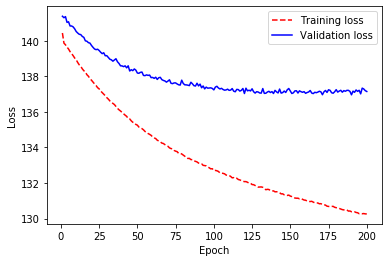

In [21]:
plot_history(hist.history)

In [7]:
def plot_history(history, what='loss', title=""):
    # Visualize loss history
    epoch_count = [i+1 for i in range(len(history[what]))]
    plt.plot(epoch_count, history[what], 'r--')
    if ('val_'+what) in history:
        plt.plot(epoch_count, history['val_'+what], 'b-')
        plt.legend(['Training '+what, 'Validation '+what])
    plt.xlabel('Epoch')
    plt.ylabel(what.capitalize())
    plt.title(title.capitalize())
    plt.show();

In [ ]:
#computing loss and generating images:
x_out = vae_model.predict(x_test)
mu, sigma, x_latent = encoder.predict(x_test)